In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import lognorm
import statsmodels.api as sm

import json
import requests
import os

from us import states

import geopandas as gpd

import shapely

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, validation_curve

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv("PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv")

In [4]:
class CDC:
    @staticmethod
    def subset_CDC_data_to_year_and_type(df, year, condition_type):
        df = df[(df.Year == year) & (df.Short_Question_Text == condition_type)]

        #subset to relevant columns
        df = df[['StateAbbr','CountyName','CountyFIPS',
                'LocationName','Measure','Data_Value',
                'Data_Value_Unit','TotalPopulation',
                'Geolocation','LocationID']].copy()
        #Calculate absolute value of population with asthma
        df['value_numeric'] = df.Data_Value.astype(float) *\
                df.TotalPopulation.astype(float) *0.01

        return df

    @staticmethod
    def format_location_ids_for_merging(df):
        #convert to same datatype, pad for merging
        df['LocationID'] = df.LocationID.astype(str)
        df['GEOID'] = df.LocationID.str.pad(width = 11,
                                                     side = "left",
                                                     fillchar = "0")
        return df

In [5]:
asthma_2019 = CDC.subset_CDC_data_to_year_and_type(df, 2019, "Current Asthma")
asthma_2019 = CDC.format_location_ids_for_merging(asthma_2019)

asthma_2019 = asthma_2019[["StateAbbr", "Data_Value", "TotalPopulation", "GEOID"]]
asthma_2019 = asthma_2019.rename(columns = {"Data_Value": "PercentageAsthma"})

asthma_2019["GEOID"] = asthma_2019.GEOID.astype(np.int64)

asthma_2019.head()

,StateAbbr,PercentageAsthma,TotalPopulation,GEOID
28,AL,10.1,5937,1049960100
78,MA,9.6,4466,25009260301
115,LA,9.2,3571,22115950704
135,AL,10.9,7023,1109189100
197,LA,12.4,4218,22105953300


In [6]:
summary_stats = pd.DataFrame(data=[[asthma_2019.PercentageAsthma.min(), 
                                   asthma_2019.PercentageAsthma.max(), 
                                   asthma_2019.PercentageAsthma.median(),
                                   asthma_2019.PercentageAsthma.mean(),
                                   asthma_2019.PercentageAsthma.std()]],
                            columns=["MinimumAsthmaRate", "MaximumAsthmaRate", "MedianAsthmaRate", "MeanAsthmaRate",
                                    "StandardDeviationAsthmaRate"])

display(summary_stats)

,MinimumAsthmaRate,MaximumAsthmaRate,MedianAsthmaRate,MeanAsthmaRate,StandardDeviationAsthmaRate
0,4.9,21.5,9.6,9.766664,1.559849


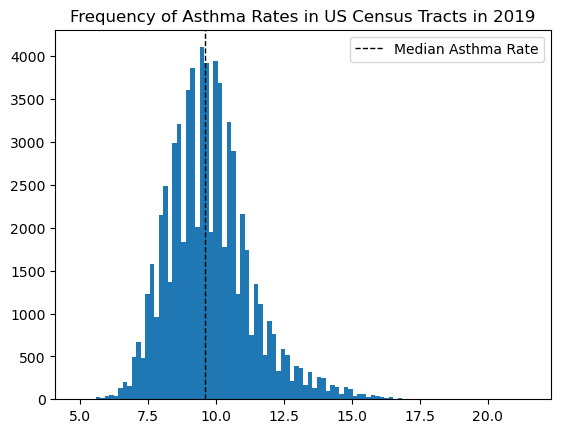

In [7]:
plt.hist(asthma_2019.PercentageAsthma, bins = 100)
plt.axvline(asthma_2019.PercentageAsthma.median(), color="black", linestyle='dashed', linewidth=1, label="Median Asthma Rate")
plt.title("Frequency of Asthma Rates in US Census Tracts in 2019")
plt.legend()

plt.savefig("asthmarates.png")
plt.show()

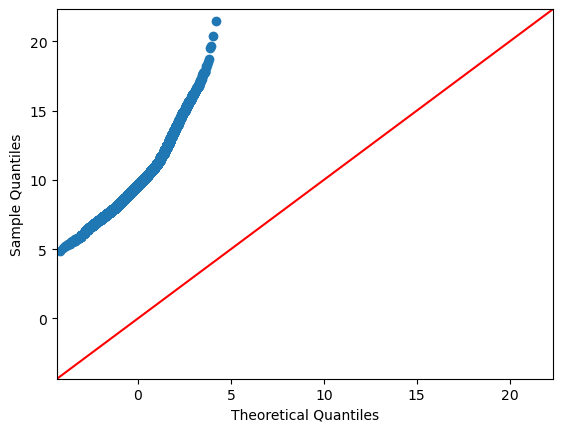

In [8]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(asthma_2019.PercentageAsthma, line='45')
plt.plot(asthma_2019.PercentageAsthma)

plt.savefig("asthmaqq.png")
plt.show()

In [9]:
with open('config.json', "r") as file:
    config = json.load(file)

In [10]:
from CensusMethods import *

vars_to_retrieve = ['B01003_001E','B03002_012E','B03002_003E',
                                    'B03002_004E','B03002_005E','B03002_006E','B03002_007E',
                                    'B03002_008E','B03002_009E', 'B17001_001E', 'B17001_002E']

c = CensusMethods(config["census"])
c.retrieve_all_variables()
relevant_values = c.retrieve_subset_of_variables(vars_to_retrieve)

relevant_values['label2'] = ['total_pop', 'hispanic','white','black',
                             'native_american','asian','pacific_islander','some_other_race','multi_race', 
                             'total_pov','below_pov_line']

In [11]:
census_data_dict = c.retrieve_bg_level_census_data_for_list_of_states_by_year(tuple(["NAME"] + vars_to_retrieve), 
                                                                     [state.abbr for state in states.STATES], 
                                                                     "*", 
                                                                     "*", 
                                                                     2019)

census = c.recode_column_names_for_retrieved_data(census_data_dict, relevant_values)

census["GEOID"] = census["state"] + census["county"] + census["tract"] + census["block group"]
census["GEOID"] = census["GEOID"].astype(np.int64)

In [64]:
def create_lc_data(filename):
    land_cover = pd.read_csv(filename)

    land_cover = land_cover[["Ag_P", "Imp_P", "Wet_P", "Green_P", "MFor_P", "bgrp"]]
    land_cover = land_cover.rename(columns={"Ag_P": "PercentAgriculture", 
                                            "Imp_P":"PercentImpervious", 
                                            "Wet_P": "PercentWetlands",
                                            "Green_P": "PercentGreenSpace", 
                                            "MFor_P": "PercentTreeCover"})
    
    return land_cover

land_cover = pd.concat([create_lc_data(f"LC_Data/{i}") for i in os.listdir("LC_Data")])

land_cover.head()

,PercentAgriculture,PercentImpervious,PercentWetlands,PercentGreenSpace,PercentTreeCover,bgrp
0,0.0,92.000000,0.0,8.000000,6.930000,245100703002
1,0.0,59.400002,0.0,40.599998,25.459999,245102718011
2,0.0,51.980000,0.0,48.020000,31.639999,245102704023
3,0.0,70.000000,0.0,30.000000,17.139999,245101608021
4,0.0,69.669998,0.0,30.330000,13.830000,245101601001


In [65]:
summary_stats = pd.DataFrame(data=[[land_cover.PercentTreeCover.min(), 
                                   land_cover.PercentTreeCover.max(), 
                                   land_cover.PercentTreeCover.median(),
                                   land_cover.PercentTreeCover.mean(),
                                   land_cover.PercentTreeCover.std()]],
                            columns=["MinimumTreeCover", "MaximumTreeCover", "MedianTreeCover", "MeanTreeCover",
                                    "StandardDeviationTreeCover"])
summary_stats.to_clipboard()
display(summary_stats)

,MinimumTreeCover,MaximumTreeCover,MedianTreeCover,MeanTreeCover,StandardDeviationTreeCover
0,0.0,94.019997,23.49,27.616933,16.338717


In [66]:
summary_stats = pd.DataFrame(data=[[land_cover.PercentAgriculture.min(), 
                                   land_cover.PercentAgriculture.max(), 
                                   land_cover.PercentAgriculture.median(),
                                   land_cover.PercentAgriculture.mean(),
                                   land_cover.PercentAgriculture.std()]],
                            columns=["MinimumAgriculturalCover", "MaximumAgriculturalCover", "MedianAgriculturalCover", 
                                     "MeanAgriculturalCover", "StandardDeviationTreeCover"])
summary_stats.to_clipboard()
display(summary_stats)

,MinimumAgriculturalCover,MaximumAgriculturalCover,MedianAgriculturalCover,MeanAgriculturalCover,StandardDeviationTreeCover
0,-888888.0,89.110001,0.0,-266370.894779,407221.114086


In [79]:
def land_cover_freq_histogram(land_cover, attribute, attribute_name):
    plt.hist(land_cover[attribute], bins = 20)
    plt.axvline(land_cover[attribute].median(), color="black", linestyle='dashed', linewidth=1, label=f"Median {attribute_name} Percentage")
    plt.title(f"Frequency of {attribute_name} Rates in US Census Block Groups")
    plt.legend()

    plt.savefig("attribute.png")
    plt.show()

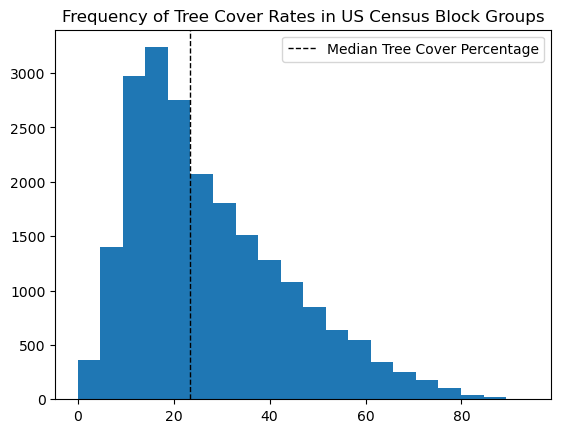

In [72]:
land_cover_freq_histogram(land_cover, "PercentTreeCover", "Tree Cover")

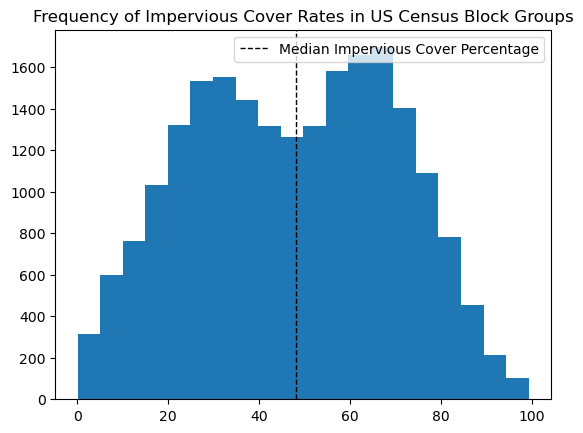

In [73]:
land_cover_freq_histogram(land_cover, "PercentImpervious", "Impervious Cover")

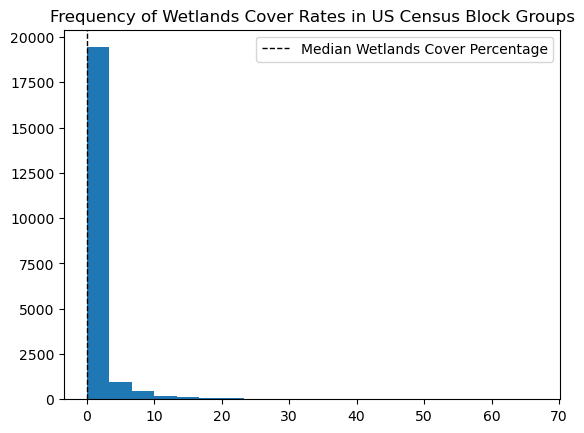

In [74]:
land_cover_freq_histogram(land_cover, "PercentWetlands", "Wetlands Cover")

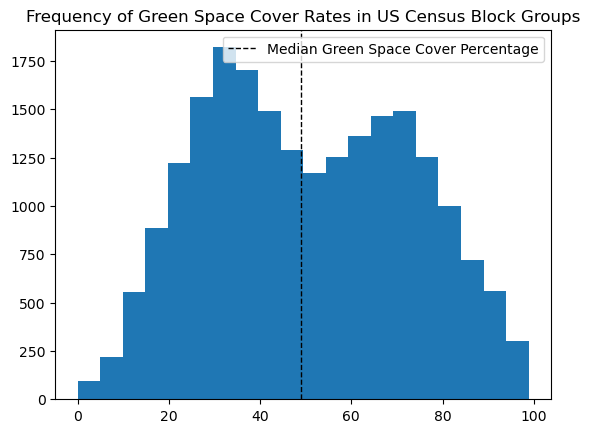

In [75]:
land_cover_freq_histogram(land_cover, "PercentGreenSpace", "Green Space Cover")

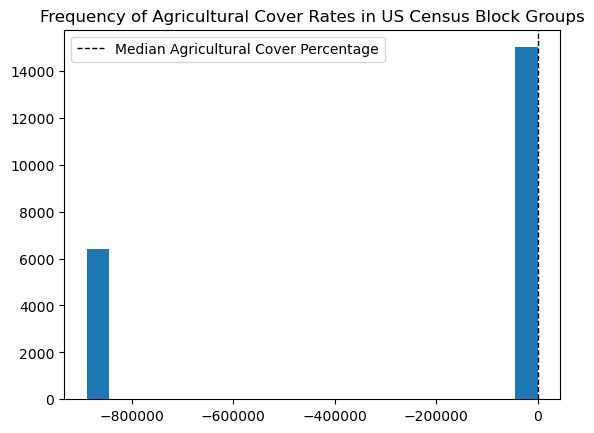

In [76]:
land_cover_freq_histogram(land_cover, "PercentAgriculture", "Agricultural Cover")

In [77]:
recoded_land_cover = land_cover.copy()
recoded_land_cover["PercentAgriculture"] = land_cover.PercentAgriculture.apply(lambda x: x if x >= 0 else 0)
land_cover_full = land_cover.copy()
land_cover_valid = land_cover[land_cover.PercentAgriculture >= 0]

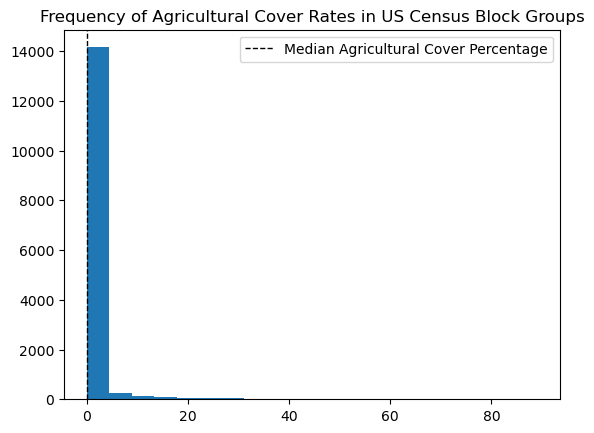

In [80]:
land_cover_freq_histogram(land_cover_valid, "PercentAgriculture", "Agricultural Cover")

In [18]:
summary_stats = pd.DataFrame(data=[[recoded_land_cover.PercentAgriculture.min(), 
                                   recoded_land_cover.PercentAgriculture.max(), 
                                   recoded_land_cover.PercentAgriculture.median(),
                                   recoded_land_cover.PercentAgriculture.mean(),
                                   recoded_land_cover.PercentAgriculture.std()]],
                            columns=["MinimumAgriculturalCover", "MaximumAgriculturalCover", "MedianAgriculturalCover", 
                                     "MeanAgriculturalCover", "StandardDeviationTreeCover"])
summary_stats.to_clipboard()
display(summary_stats)

,MinimumAgriculturalCover,MaximumAgriculturalCover,MedianAgriculturalCover,MeanAgriculturalCover,StandardDeviationTreeCover
0,0.0,89.110001,0.0,0.965398,6.094077


In [19]:
summary_stats = pd.DataFrame(data=[[land_cover_valid.PercentAgriculture.min(), 
                                   land_cover_valid.PercentAgriculture.max(), 
                                   land_cover_valid.PercentAgriculture.median(),
                                   land_cover_valid.PercentAgriculture.mean(),
                                    land_cover_valid.PercentAgriculture.std()]],
                            columns=["MinimumAgriculturalCover", "MaximumAgriculturalCover", "MedianAgriculturalCover", 
                                     "MeanAgriculturalCover", "StandardDeviationTreeCover"])
summary_stats.to_clipboard()
display(summary_stats)

,MinimumAgriculturalCover,MaximumAgriculturalCover,MedianAgriculturalCover,MeanAgriculturalCover,StandardDeviationTreeCover
0,0.0,89.110001,0.0,1.378487,7.242958


In [20]:
def create_bg_data(filename):
    bg_all = pd.read_csv(filename)

    bg_all = bg_all[["Shape_Area", "bgrp", "geometry"]]
    bg_all["GEOID"] = bg_all.bgrp
    
    return bg_all

In [21]:
bg_all = pd.concat([create_bg_data(f"BG_Data/{i}") for i in os.listdir("BG_Data")])

In [22]:
def aggregate_to_tract_level(df):
    
    # Convert from percentages to raw numbers
    for col in df.columns:
        if "Percent" in col:
            df[col] = df[col] / 100
            df[col.replace("Percent", "")] = df[col] * df["Shape_Area"]
            df = df.drop(col, axis=1)
    
    geom = [shapely.wkt.loads(x) for x in df.geometry]
    
    gdf = gpd.GeoDataFrame(df, 
                           crs = {'init':'EPSG:4326'}, 
                           geometry = geom)

    tract_level_data = gdf.dissolve(by = ["state", "county", "tract"], aggfunc = "sum")
        
    raw_columns = ["Agriculture", "Impervious", "Wetlands", "GreenSpace", "TreeCover"]

    # Convert back to Percentages
    for col in raw_columns:
        tract_level_data[f"Percent{col}"] = tract_level_data[col] / tract_level_data["Shape_Area"]
        tract_level_data = tract_level_data.drop(col, axis=1)
    
    tract_level_data = tract_level_data.reset_index()

    tract_level_data["GEOID"] = tract_level_data.GEOID / 10
    tract_level_data["GEOID"] = tract_level_data["GEOID"].astype(np.int64)
    
    return tract_level_data

def create_final_dataset(land_cover_df, bg_df, census_df, asthma_df):
    merged_data = land_cover_df.merge(bg_df, how="left", on="bgrp").merge(census_df, how="left", on="GEOID")
    tract_level_data = aggregate_to_tract_level(merged_data)
    final_dataset = tract_level_data.merge(asthma_2019, how="inner", on="GEOID")
    final_dataset["RoundedAsthma"] = final_dataset.PercentageAsthma.round()
    final_dataset["state"] = final_dataset.state.astype(np.int64)
    return final_dataset

In [23]:
def get_train_test_split(df, x = None):
    y = df.PercentageAsthma
    if x is None:
        x = df[["total_pop", "state", "PercentAgriculture", 
                       "PercentImpervious", "PercentWetlands", "PercentGreenSpace", "PercentTreeCover"]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)
    return (X_train, X_test, y_train, y_test)

def linear_regression_func(final_dataset):
    X_train, X_test, y_train, y_test = get_train_test_split(final_dataset)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_lr = model.predict(X_test)

    get_metrics(model, X_test, y_test)
    
    return [y_test, y_pred_lr]

def poly_regression_func(final_dataset):
    poly = PolynomialFeatures(degree=2, include_bias=False)
    
    x = final_dataset[["total_pop", "state", "PercentAgriculture", 
                       "PercentImpervious", "PercentWetlands", "PercentGreenSpace", "PercentTreeCover"]]
    poly_features = poly.fit_transform(x)
    
    X_train, X_test, y_train, y_test = get_train_test_split(final_dataset, poly_features)
    
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_train, y_train)
    
    get_metrics(poly_reg_model, X_test, y_test)
    return [y_test, poly_reg_model.predict(X_test)]

def knn_validation_curve(final_dataset):
    model = KNeighborsRegressor()

    y = final_dataset.PercentageAsthma
    x = final_dataset[["total_pop", "state", "PercentAgriculture", 
                           "PercentImpervious", "PercentWetlands", "PercentGreenSpace", "PercentTreeCover"]]

    model.fit(x, y)

    neighbors = np.arange(1,30, 1)
    train_scores, test_scores = validation_curve(model, x, y, param_name='n_neighbors',
                                                param_range=neighbors)
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    fig1 = plt.figure()
    plt.plot(neighbors, train_mean, label='Train')
    plt.plot(neighbors, test_mean, label='Test')
    plt.xlabel("# of Neighbours")
    plt.ylabel('Score')
    plt.title('KNN Validation Curve')
    plt.legend()
    plt.show()

def knn_func(final_dataset, k):
    X_train, X_test, y_train, y_test = get_train_test_split(final_dataset)
    
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, y_train)

    get_metrics(knn, X_test, y_test)
    return [y_test, knn.predict(X_test)]

def histogram(y_pred, y_test, degree = None):
    bins = np.linspace(5, 20, 20)

    plt.hist(y_pred, bins, alpha=0.5, label='Predicted Rate')
    plt.hist(y_test, bins, alpha=0.5, label='Actual Rate')
    
    if degree == 1:
        plt.title("Frequencies of Predicted and Actual Asthma Rates (Linear Regression)")
    elif degree == 2:
        plt.title("Frequencies of Predicted and Actual Asthma Rates (Quadratic Regression)")
    elif degree is None:
        plt.title("Frequencies of Predicted and Actual Asthma Rates (KNN)")
    plt.xlabel("Asthma Rate")
    plt.legend(loc='upper right')
    plt.show()
    
def r2_scores(ytrue, ypredicted, p):
    df = pd.DataFrame({"true": ytrue, "predicted": ypredicted})
    r2 = 1 - df.apply(lambda x: (x.true - x.predicted) ** 2, axis=1).sum() / df.apply(lambda x: (x.true - ytrue.mean()) ** 2, axis=1).sum()
    r2_adj = 1 - ((1 - r2) ** 2).item()*(len(df) - 1)/(len(df) - p - 1)
    return (r2, r2_adj)
    
def get_metrics(model, x, y):
    r2, r2_adj = r2_scores(y, model.predict(x), x.shape[1])
    mse = mean_squared_error(y, model.predict(x))
    print("Metrics for", type(model).__name__)
    print("R^2: ", r2)
    print("Adjusted R^2", r2_adj)
    print("Mean Squared Error", mse)
    print()

In [55]:
# Limit dataset to plausible values for PercentAgriculture

final_dataset = create_final_dataset(land_cover_valid, bg_all, census, asthma_2019)
l = linear_regression_func(final_dataset)

Metrics for LinearRegression
R^2:  0.09535333826360337
Adjusted R^2 0.13265117742512822
Mean Squared Error 3.571965355560203



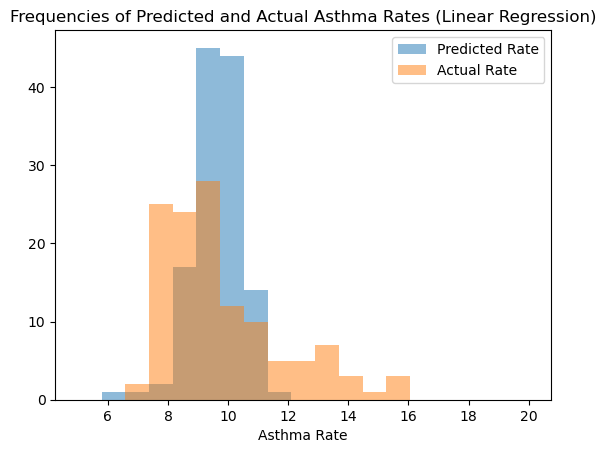

In [25]:
y_test = l[0]
y_pred_lr = l[1]
histogram(y_pred_lr, y_test, 1)

In [26]:
poly_pred = poly_regression_func(final_dataset)

y_test = poly_pred[0]
y_pred = poly_pred[1]

Metrics for LinearRegression
R^2:  0.05969510462869376
Adjusted R^2 -0.23188189591175457
Mean Squared Error 3.7127606301925025



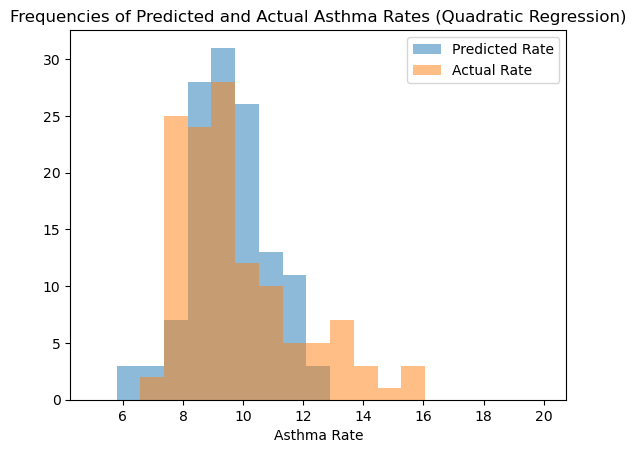

In [27]:
histogram(y_pred, y_test, 2)

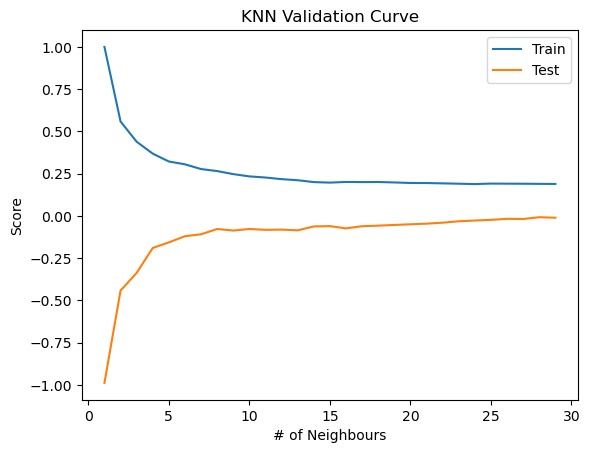

In [28]:
knn_validation_curve(final_dataset)

In [29]:
knn_pred = knn_func(final_dataset, 15)

y_test = knn_pred[0]
y_pred = knn_pred[1]

Metrics for KNeighborsRegressor
R^2:  0.12196576968431139
Adjusted R^2 0.18293102913545378
Mean Squared Error 3.4668871111111126



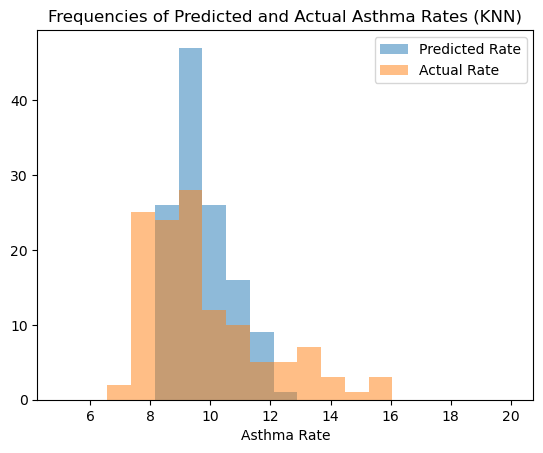

In [30]:
histogram(y_pred, y_test)

(666, 25)
Metrics for LinearRegression
R^2:  0.08798652027747988
Adjusted R^2 0.13790651639624818
Mean Squared Error 3.705642098053679



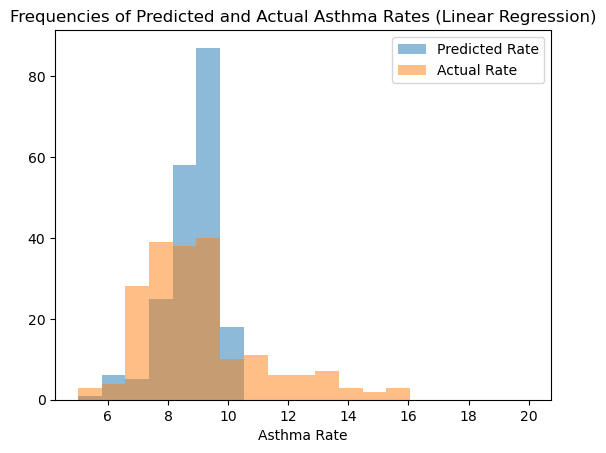

In [56]:
# Predictions and histograms with recoded data

final_dataset = create_final_dataset(recoded_land_cover, bg_all, census, asthma_2019)
print(final_dataset.shape)

l = linear_regression_func(final_dataset)

y_test = l[0]
y_pred_lr = l[1]

histogram(y_pred_lr, y_test, 1)

Metrics for LinearRegression
R^2:  0.30754251796442544
Adjusted R^2 0.4181708809696185
Mean Squared Error 2.8135544633879523



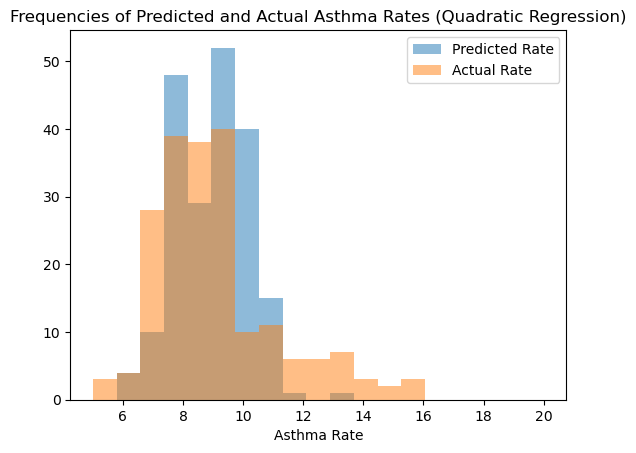

In [32]:
poly_pred = poly_regression_func(final_dataset)

y_test = poly_pred[0]
y_pred = poly_pred[1]

histogram(y_pred, y_test, 2)

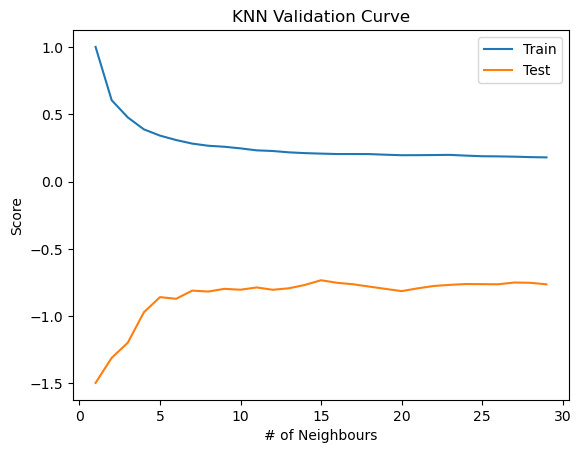

In [33]:
knn_validation_curve(final_dataset)

In [59]:
knn_pred = knn_func(final_dataset, 20)

y_test = knn_pred[0]
y_pred = knn_pred[1]

Metrics for KNeighborsRegressor
R^2:  0.035039368528410275
Adjusted R^2 0.034902838345209464
Mean Squared Error 3.9207740000000006



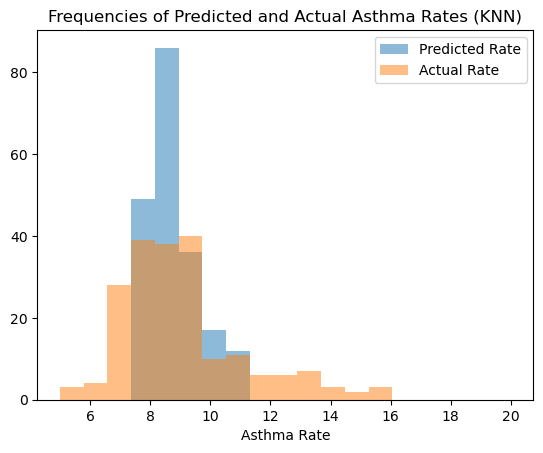

In [60]:
histogram(y_pred, y_test)

In [36]:
# fill values with prediction from regression

land_cover_filled = land_cover_full.copy()

y_train = land_cover_filled[land_cover_filled.PercentAgriculture >= 0].PercentAgriculture
y_test = land_cover_filled[land_cover_filled.PercentAgriculture < 0].PercentAgriculture
X_train = land_cover_filled[land_cover_filled.PercentAgriculture >= 0].drop("PercentAgriculture", axis = 1)
X_test = land_cover_filled[land_cover_filled.PercentAgriculture < 0].drop("PercentAgriculture", axis = 1)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)

In [37]:
land_cover_filled.loc[land_cover_filled.PercentAgriculture < 0, "PercentAgriculture"] = y_pred_lr

In [52]:
full_dataset_with_regression = create_final_dataset(land_cover_filled, bg_all, census, asthma_2019)

Metrics for LinearRegression
R^2:  0.08409875364083053
Adjusted R^2 0.13054091914909527
Mean Squared Error 3.721438653736781



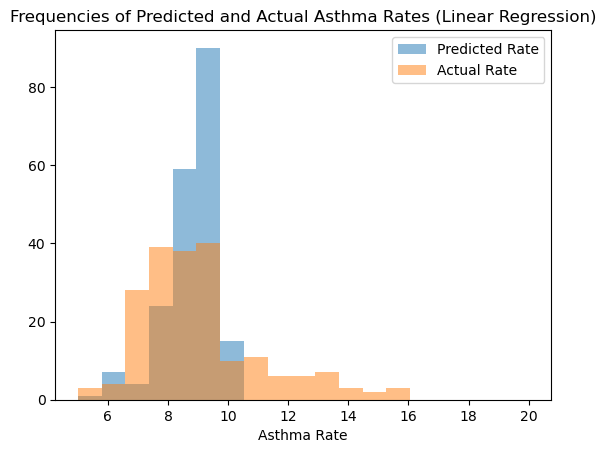

In [53]:
l = linear_regression_func(full_dataset_with_regression)
y_test = l[0]
y_pred_lr = l[1]

histogram(y_pred_lr, y_test, 1)

Metrics for LinearRegression
R^2:  0.31092128871255675
Adjusted R^2 0.4238349719538833
Mean Squared Error 2.799826031295307



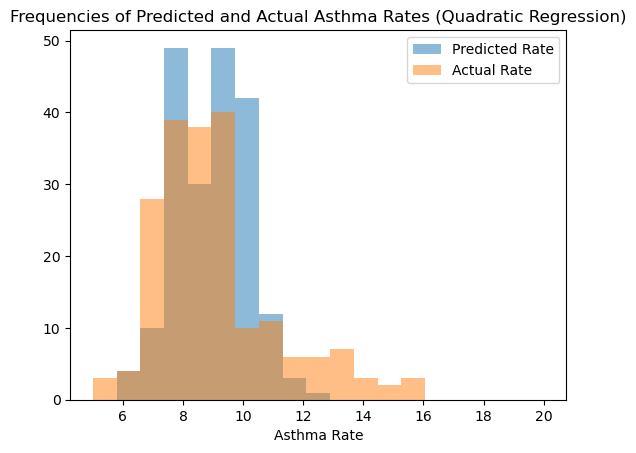

In [54]:
poly_pred = poly_regression_func(full_dataset_with_regression)

y_test = poly_pred[0]
y_pred = poly_pred[1]

histogram(y_pred, y_test, 2)

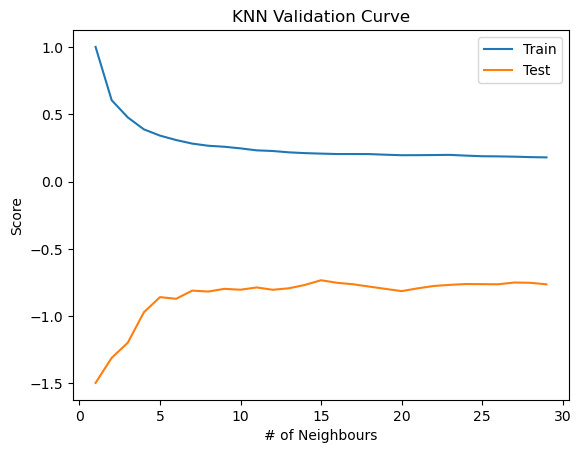

In [62]:
knn_validation_curve(full_dataset_with_regression)

Metrics for KNeighborsRegressor
R^2:  0.027640117548818566
Adjusted R^2 0.0200454976088823
Mean Squared Error 3.950838222222223



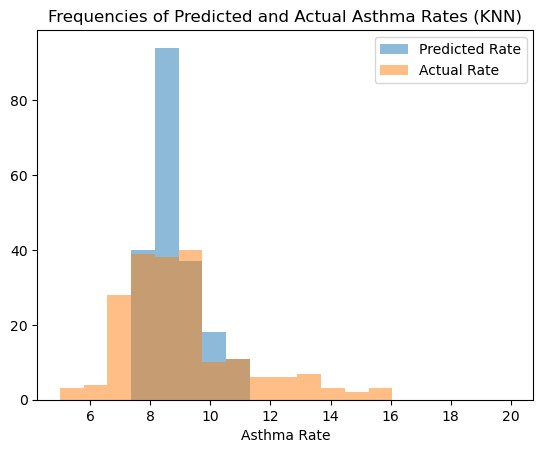

In [42]:
knn = knn_func(full_dataset_with_regression, 15)
y_test = knn[0]
y_pred = knn[1]

histogram(y_pred, y_test)

In [43]:
# Models run with unprocessed data for comparison point
full_dataset = create_final_dataset(land_cover_full, bg_all, census, asthma_2019)

In [44]:
l = linear_regression_func(full_dataset)

Metrics for LinearRegression
R^2:  0.27166173163050733
Adjusted R^2 0.45018307291081905
Mean Squared Error 2.9593432650958937



In [45]:
poly_pred = poly_regression_func(full_dataset)

Metrics for LinearRegression
R^2:  0.27875820113170857
Adjusted R^2 0.3687941661309816
Mean Squared Error 2.930509287620905



In [46]:
knn = knn_func(full_dataset, 20)

Metrics for KNeighborsRegressor
R^2:  0.22243181634714404
Adjusted R^2 0.3733445637207755
Mean Squared Error 3.1593714999999998

